In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

In [4]:
# 보조 데이터 Set
age_gender = pd.read_csv("../data/age_gender_bkts.csv")
countries = pd.read_csv("../data/countries.csv")
sessions = pd.read_csv("../data/sessions.csv")

In [5]:
train = pd.read_csv("../data/train_users_2.csv")
test = pd.read_csv("../data/test_users.csv")
ss = pd.read_csv("../data/sample_submission_NDF.csv")

In [6]:
# train / test columns 비교
set(train.columns) - set(test.columns)

{'country_destination'}

In [7]:
train.shape, test.shape

((213451, 16), (62096, 15))

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
id                         213451 non-null object
date_account_created       213451 non-null object
timestamp_first_active     213451 non-null int64
date_first_booking         88908 non-null object
gender                     213451 non-null object
age                        125461 non-null float64
signup_method              213451 non-null object
signup_flow                213451 non-null int64
language                   213451 non-null object
affiliate_channel          213451 non-null object
affiliate_provider         213451 non-null object
first_affiliate_tracked    207386 non-null object
signup_app                 213451 non-null object
first_device_type          213451 non-null object
first_browser              213451 non-null object
country_destination        213451 non-null object
dtypes: float64(1), int64(2), object(13)
memory usage: 26.1+ MB


In [9]:
train.isnull().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

In [10]:
for col in train.columns:
    print("{col} : {count}".format(col=col, count=len(train[col].unique())))

id : 213451
date_account_created : 1634
timestamp_first_active : 213451
date_first_booking : 1977
gender : 4
age : 128
signup_method : 3
signup_flow : 17
language : 25
affiliate_channel : 8
affiliate_provider : 18
first_affiliate_tracked : 8
signup_app : 4
first_device_type : 9
first_browser : 52
country_destination : 12


In [11]:
train.tail()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
213446,zxodksqpep,2014-06-30,20140630235636,NaN,MALE,32.0,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari,NDF
213447,mhewnxesx9,2014-06-30,20140630235719,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,NDF
213448,6o3arsjbb4,2014-06-30,20140630235754,NaN,-unknown-,32.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NDF
213449,jh95kwisub,2014-06-30,20140630235822,NaN,-unknown-,NaN,basic,25,en,other,other,tracked-other,iOS,iPhone,Mobile Safari,NDF
213450,nw9fwlyb5f,2014-06-30,20140630235824,NaN,-unknown-,NaN,basic,25,en,direct,direct,untracked,iOS,iPhone,-unknown-,NDF


## 1. Target (Destination) 탐색

In [12]:
print(train['country_destination'].unique())

['NDF' 'US' 'other' 'FR' 'CA' 'GB' 'ES' 'IT' 'PT' 'NL' 'DE' 'AU']


In [13]:
# 나라별로 Count 
data1 = train.groupby('country_destination').aggregate({'id':'count'}).reset_index()
data1.sort_values(by=['id'], ascending=False)

,country_destination,id
7,NDF,124543
10,US,62376
11,other,10094
4,FR,5023
6,IT,2835
5,GB,2324
3,ES,2249
1,CA,1428
2,DE,1061
8,NL,762


Countries Category가 12개

예외 1) NDF : Do Not Make a booking (58.35%)
 
예외 2) others : 4.7%

In [14]:
124543/213451, 10094/213451

(0.5834734904029496, 0.04728954186206671)

### 1.1 여행지 비율

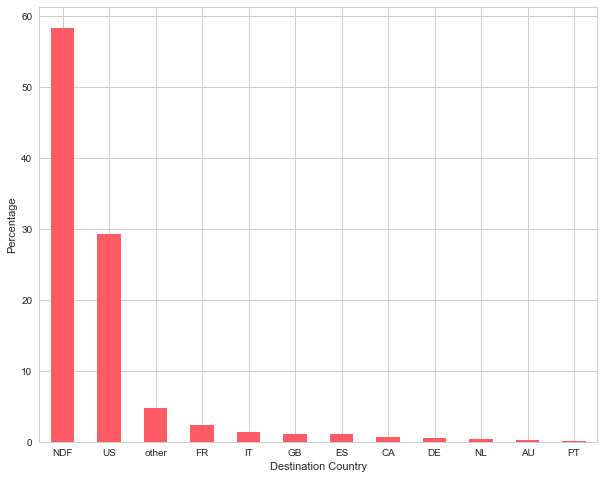

In [15]:
plt.figure(figsize=(10,8))
destination_percentage = train.country_destination.value_counts() / train.shape[0] * 100
destination_percentage.plot(kind='bar',color='#FD5C64', rot=0)


plt.xlabel('Destination Country')
plt.ylabel('Percentage')
plt.show()

## 2. Gender Column 탐색

In [16]:
data2 = train.groupby('gender').aggregate({'id':'count'}).reset_index()
data2.sort_values(by=['id'], ascending=False)

,gender,id
0,-unknown-,95688
1,FEMALE,63041
2,MALE,54440
3,OTHER,282


unknown 값을 어떻게 처리할까?

idea1) train data의 나이를 참조해서 age_gender의 나이대에 성별을 랜덤하게 입력?

idea2) 성별이 영향이 있을까? 동반자 데이터가 없는데. 혼자가 아닌 이상 영향이 없을 것 같다는 생각도 듬 : age_gender 데이터를 통해 극명하게 성별에 따른 우위가 있는 여행지가 있는지 확인

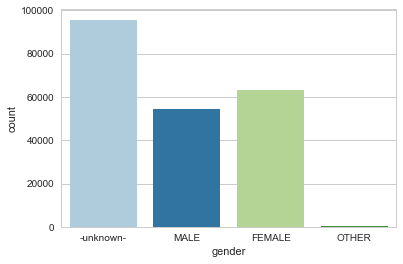

In [17]:
sns.countplot(x=train.gender, palette='Paired')
plt.show()

### 2.1 성별에 따른 여행지 선호도가 달라질까?

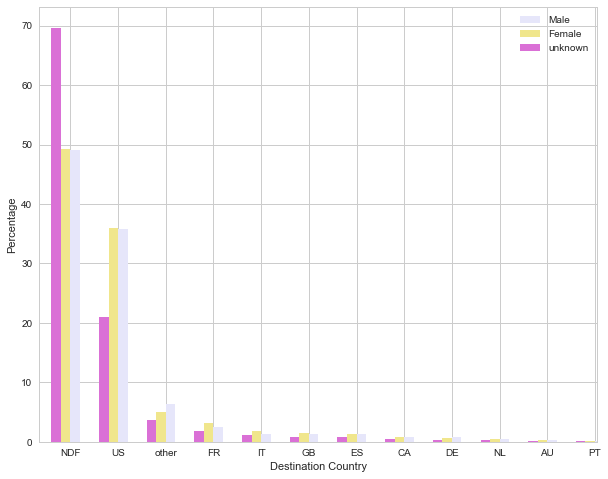

In [106]:
female_destinations = train.loc[train['gender'] == 'FEMALE', 'country_destination'].value_counts() / sum(train['gender'] == 'FEMALE') * 100
male_destinations = train.loc[train['gender'] == 'MALE', 'country_destination'].value_counts() / sum(train['gender'] == 'MALE') * 100
unknown_destinations = train.loc[train['gender'] == '-unknown-', 'country_destination'].value_counts() / sum(train['gender'] == '-unknown-') * 100

plt.figure(figsize=(10,8))
male_destinations.plot(kind='bar', width=0.2, color='lavender', position=0, label='Male', rot=0)
female_destinations.plot(kind='bar', width=0.2, color='khaki', position=1, label='Female', rot=0)
unknown_destinations.plot(kind='bar', width=0.2, color='orchid', position=2, label='unknown', rot=0)

plt.legend()
plt.xlabel('Destination Country')
plt.ylabel('Percentage')


plt.show()

프랑스, 이탈리아, 영국: 여성 선호 (패션, 아름다움)

캐나다, 독일, 네덜란드 : 남성선호 (Extrme, 맥주, 성, 축구)

## 3. Age Column 탐색 (# of NaN = 87,990)

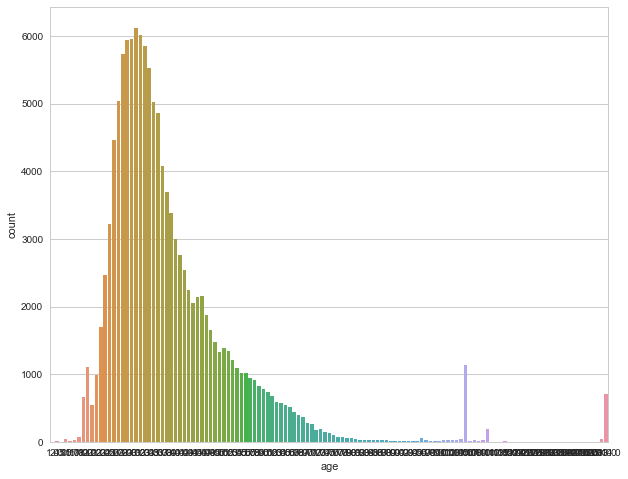

In [19]:
plt.figure(figsize=(10,8))

sns.countplot(x=train.age.dropna())
plt.show()

In [112]:
train2 = train

bins = [0, 30, 60, 100]
group_names = ["younger", "family", "older"]
train2['group_age'] = pd.cut(train['age'], bins, labels=group_names, right=False)

In [118]:
train2['group_age'].dropna(axis=0, how='any')

1          family
2          family
3          family
4          family
6          family
7          family
8          family
9          family
10         family
11         family
13         family
14         family
15         family
17         family
19        younger
21         family
22         family
24         family
25        younger
27         family
28         family
29         family
30         family
31         family
32         family
33        younger
34         family
35         family
36         family
37         family
           ...   
213390     family
213391    younger
213393    younger
213395     family
213398     family
213400     family
213401     family
213402     family
213403    younger
213405    younger
213406     family
213407    younger
213408      older
213409    younger
213410     family
213412     family
213415     family
213417     family
213423    younger
213424     family
213425     family
213430    younger
213432     family
213439     family
213440    

young 
 NDF      45.589552
US       39.106851
other     5.771763
FR        2.675233
IT        1.603560
ES        1.579862
GB        1.295487
CA        0.729370
DE        0.689873
NL        0.531887
AU        0.297541
PT        0.129022
Name: country_destination, dtype: float64 
 family 
 NDF      44.962389
US       39.007165
other     6.160841
FR        3.070203
IT        1.588741
GB        1.412498
ES        1.266906
CA        0.923360
DE        0.661550
NL        0.443162
AU        0.376751
PT        0.126435
Name: country_destination, dtype: float64 
 older 
 NDF      49.449420
US       33.387168
other     5.814124
FR        3.420937
GB        2.055498
IT        1.996770
ES        1.247981
DE        0.807517
CA        0.807517
NL        0.601967
AU        0.293643
PT        0.117457
Name: country_destination, dtype: float64


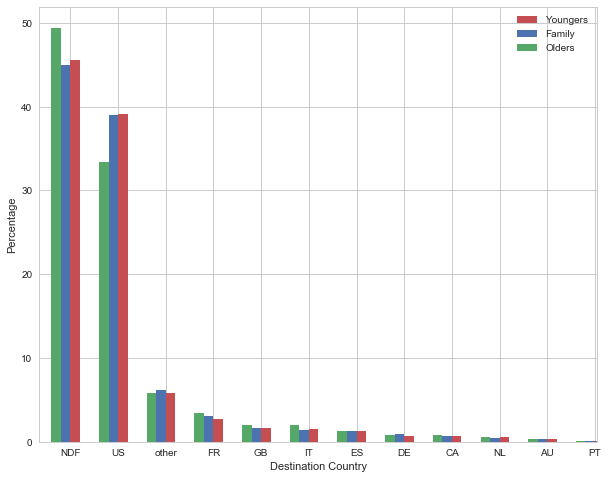

In [133]:
younger = sum(train2['group_age'] == 'younger')
family = sum(train2['group_age'] == 'family')
older = sum(train2['group_age'] == 'older')

younger_destinations = train2.loc[train2['group_age'] == 'younger', 'country_destination'].value_counts() / younger * 100
family_destinations = train2.loc[train2['group_age'] == 'family', 'country_destination'].value_counts() / family * 100
older_destinations = train2.loc[train2['group_age'] == 'older', 'country_destination'].value_counts() / older * 100

print("young", "\n", younger_destinations,"\n", "family", "\n", family_destinations,"\n", "older", "\n", older_destinations)

plt.figure(figsize=(10,8))
younger_destinations.plot(kind='bar', width=0.2, color='r', position=0, label='Youngers', rot=0)
family_destinations.plot(kind='bar', width=0.2, color='b', position=1, label='Family', rot=0)
older_destinations.plot(kind='bar', width=0.2, color='g', position=2, label='Olders', rot=0)


plt.legend()
plt.xlabel('Destination Country')
plt.ylabel('Percentage')

plt.show()


In [124]:
data3 = train[train.age > 100]
data3

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,group_age
388,v2x0ms9c62,2010-04-11,20100411065602,2010-04-13,-unknown-,2014.0,basic,3,en,other,craigslist,untracked,Web,Windows Desktop,Firefox,FR,NaN
398,9ouah6tc30,2010-04-12,20100412231534,2010-04-12,FEMALE,104.0,facebook,3,en,other,craigslist,linked,Web,iPhone,Mobile Safari,FR,NaN
627,dc3udjfdij,2010-05-19,20100519012455,2010-06-16,-unknown-,105.0,basic,2,en,other,craigslist,omg,Web,Mac Desktop,Safari,FR,NaN
673,umf1wdk9uc,2010-05-25,20100525155541,NaN,FEMALE,2014.0,basic,2,en,other,craigslist,untracked,Web,Mac Desktop,Safari,NDF,NaN
1040,m82epwn7i8,2010-07-14,20100714230556,2010-07-15,MALE,2014.0,facebook,0,en,other,craigslist,untracked,Web,Mac Desktop,Chrome,US,NaN
1177,2th813zdx7,2010-07-25,20100725234419,2010-07-26,MALE,2013.0,facebook,3,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US,NaN
1190,qc9se9qucz,2010-07-27,20100727002029,2010-07-27,-unknown-,105.0,basic,2,en,other,craigslist,untracked,Web,Mac Desktop,Firefox,US,NaN
1200,3amf04n3o3,2010-07-27,20100727190447,2010-07-29,FEMALE,2014.0,basic,2,en,direct,direct,untracked,Web,Windows Desktop,IE,US,NaN
1208,cguxptdi6h,2010-07-28,20100728034415,2010-07-28,-unknown-,105.0,basic,3,en,direct,direct,untracked,Web,Mac Desktop,Firefox,US,NaN
1239,6vpmryt377,2010-07-30,20100730055204,2010-07-30,FEMALE,2014.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,CA,NaN


In [125]:
data3_1 = data3.groupby('age').aggregate({'id':'count'}).reset_index()
data3_1

,age,id
0,101.0,23
1,102.0,34
2,103.0,26
3,104.0,48
4,105.0,1131
5,106.0,17
6,107.0,23
7,108.0,15
8,109.0,31
9,110.0,196


기네스북 최고령자는 146세, 가장 최근은 116세

1924~2008은 생년월일을 잘못 입력한 듯

2013, 2014는 해당년도로 잘못분류 된듯

나이 데이터는 중요할 것으로 판단되는데... 어떻게 처리할지...

## 4. date_first_booking 데이터 

In [ ]:
train.date_first_booking.isnull().sum()

In [ ]:
train[train.date_first_booking.notnull()].date_first_booking.describe()

In [ ]:
data4 = train.groupby('date_first_booking').aggregate({'id':'count'}).reset_index()
data4

Null 값은 NDF 숫자와 같음

NDF를 왜 넣어뒀을까?

도착지 예측을 위해서가 아니라 그냥 마케팅적으로 이용하기위해 데이터를 다 담아둔 것을까?

## 5. Sign_up Data

In [92]:
train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [93]:
print(sessions['action_detail'].unique())

[nan 'view_search_results' 'wishlist_content_update' 'similar_listings'
 'change_trip_characteristics' 'p3' 'header_userpic' 'contact_host'
 'message_post' '-unknown-' 'dashboard' 'create_user' 'confirm_email_link'
 'user_profile_content_update' 'user_profile' 'pending' 'p5'
 'create_phone_numbers' 'cancellation_policies' 'user_wishlists'
 'change_contact_host_dates' 'wishlist' 'message_thread'
 'request_new_confirm_email' 'send_message' 'your_trips' 'login_page'
 'login' 'login_modal' 'toggle_archived_thread' 'p1'
 'profile_verifications' 'edit_profile' 'oauth_login'
 'post_checkout_action' 'account_notification_settings'
 'update_user_profile' 'oauth_response' 'signup_modal' 'signup_login_page'
 'at_checkpoint' 'manage_listing' 'create_listing' 'your_listings'
 'profile_references' 'list_your_space' 'popular_wishlists'
 'listing_reviews_page' 'apply_coupon' 'user_tax_forms'
 'account_payout_preferences' 'guest_itinerary' 'guest_receipt'
 'account_privacy_settings' 'lookup_message_thr

In [94]:
df_signup = train.loc[:, ['gender', 'age', 'language', 'signup_method', 'signup_flow', 'signup_app', 'country_destination']]
df_signup.tail()

,gender,age,language,signup_method,signup_flow,signup_app,country_destination
213446,MALE,32.0,en,basic,0,Web,NDF
213447,-unknown-,NaN,en,basic,0,Web,NDF
213448,-unknown-,32.0,en,basic,0,Web,NDF
213449,-unknown-,NaN,en,basic,25,iOS,NDF
213450,-unknown-,NaN,en,basic,25,iOS,NDF


In [95]:
method_label = train['signup_method'].unique()
print(method_label)

['facebook' 'basic' 'google']


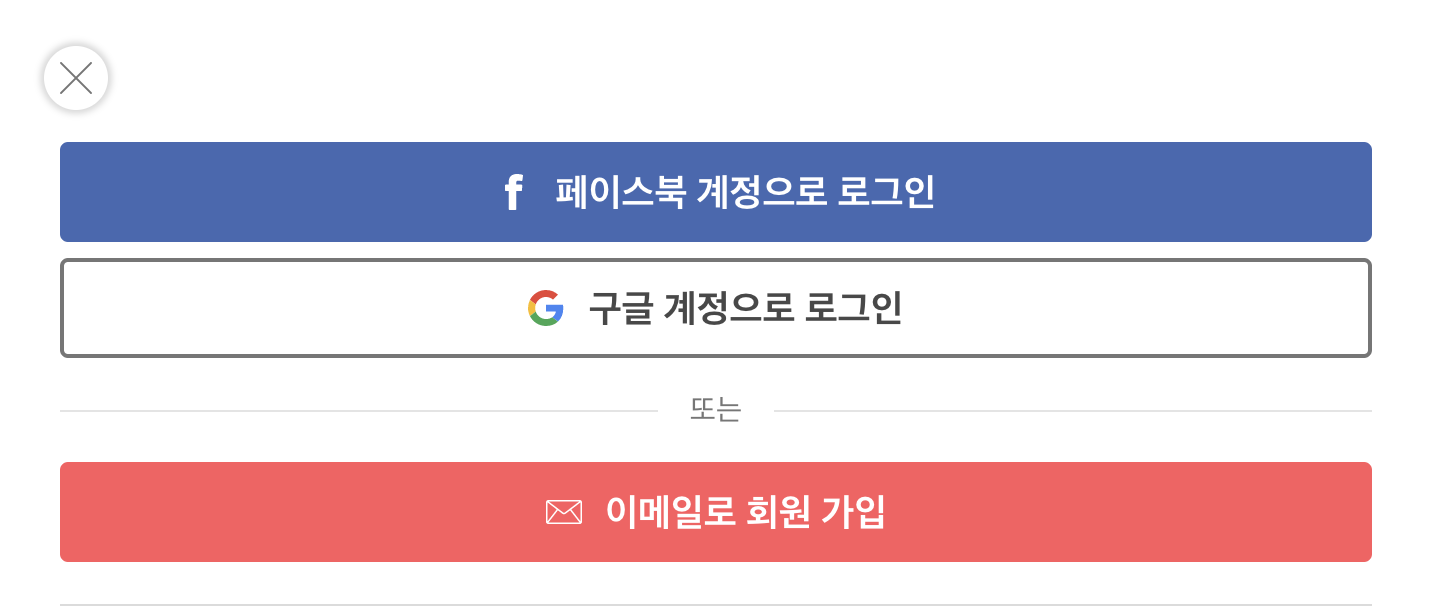

In [91]:
Image.open('sign_up.png')

In [24]:
app_label = train['signup_app'].unique()
print(app_label)

['Web' 'Moweb' 'iOS' 'Android']


In [96]:
df_signup.tail()

,gender,age,language,signup_method,signup_flow,signup_app,country_destination
213446,MALE,32.0,en,basic,0,Web,NDF
213447,-unknown-,NaN,en,basic,0,Web,NDF
213448,-unknown-,32.0,en,basic,0,Web,NDF
213449,-unknown-,NaN,en,basic,25,iOS,NDF
213450,-unknown-,NaN,en,basic,25,iOS,NDF


In [97]:
df_signup.pivot_table(columns='country_destination', index=['signup_method', 'signup_app'],values='gender', aggfunc="count")

country_destination          AU      CA     DE      ES      FR      GB  \
signup_method signup_app                                                 
basic         Android       2.0    12.0    5.0    16.0    17.0     9.0   
              Moweb        11.0    23.0   13.0    27.0    45.0    26.0   
              Web         360.0  1029.0  689.0  1492.0  3557.0  1611.0   
              iOS          20.0    41.0   30.0    66.0   148.0    81.0   
facebook      Android       1.0     2.0    3.0     7.0     6.0     7.0   
              Moweb         3.0     6.0    2.0     7.0    11.0     7.0   
              Web         130.0   296.0  307.0   593.0  1162.0   548.0   
              iOS          12.0    18.0   11.0    39.0    74.0    35.0   
google        Android       NaN     1.0    1.0     2.0     3.0     NaN   

country_destination           IT      NDF     NL     PT       US   other  
signup_method signup_app                                                  
basic         Android       12.0   2903.0    6.0    1.0    584.0   124.0  
              Moweb         21.0   3028.0   11.0    3.0   1305.0   142.0  
              Web         2005.0  72232.0  515.0  142.0  40875.0  6730.0  
              iOS          109.0   9683.0   28.0    8.0   2666.0   434.0  
facebook      Android        7.0    873.0    2.0    NaN    274.0    35.0  
              Moweb         10.0   1090.0    3.0    NaN    413.0    54.0  
              Web          634.0  30464.0  186.0   58.0  14770.0  2332.0  
              iOS           35.0   3825.0   11.0    4.0   1410.0   231.0  
google        Android        2.0    445.0    NaN    1.0     79.0    12.0

## 6. Affiliate (제휴 마케팅)

In [28]:
df_affiliate = train.loc[:, ['gender', 'age', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'country_destination']]
df_affiliate.tail()

,gender,age,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,country_destination
213446,MALE,32.0,en,sem-brand,google,omg,NDF
213447,-unknown-,NaN,en,direct,direct,linked,NDF
213448,-unknown-,32.0,en,direct,direct,untracked,NDF
213449,-unknown-,NaN,en,other,other,tracked-other,NDF
213450,-unknown-,NaN,en,direct,direct,untracked,NDF


In [29]:
print(train['affiliate_channel'].unique())

['direct' 'seo' 'other' 'sem-non-brand' 'content' 'sem-brand'
 'remarketing' 'api']


seo : 검색최적화 / sem : 검색엔진마케팅 / content : 컨텐츠 제작광고

remarketing : 방문자 대상으로 광고

In [30]:
print("제휴마케팅 제공자 : {}".format(len(train['affiliate_provider'].unique())))
print(train['affiliate_provider'].unique())

제휴마케팅 제공자 : 18
['direct' 'google' 'other' 'craigslist' 'facebook' 'vast' 'bing' 'meetup'
 'facebook-open-graph' 'email-marketing' 'yahoo' 'padmapper' 'gsp' 'wayn'
 'naver' 'baidu' 'yandex' 'daum']


In [31]:
print("유입 경로 : {}".format(len(train['first_affiliate_tracked'].unique())))
print(train['first_affiliate_tracked'].unique())

유입 경로 : 8
['untracked' 'omg' nan 'linked' 'tracked-other' 'product' 'marketing'
 'local ops']


In [34]:
df_affiliate.pivot_table(columns='country_destination', index=['affiliate_channel', 'affiliate_provider'],values='gender', aggfunc="count")

country_destination                       AU     CA     DE      ES      FR  \
affiliate_channel affiliate_provider                                         
api               other                 17.0   30.0   22.0    56.0    87.0   
content           facebook               NaN    2.0    1.0     8.0     1.0   
                  google                 6.0   15.0    4.0    18.0    55.0   
                  gsp                    1.0    NaN    NaN     NaN     1.0   
                  other                  NaN    NaN    NaN     NaN     NaN   
                  yandex                 NaN    NaN    NaN     NaN     NaN   
direct            direct               362.0  943.0  699.0  1528.0  3281.0   
                  other                  1.0    2.0    NaN     8.0    13.0   
other             craigslist             4.0   39.0   18.0    11.0    60.0   
                  email-marketing        NaN    NaN    NaN     NaN     NaN   
                  facebook-open-graph    1.0    4.0    2.0     2.0    10.0   
                  meetup                 NaN    NaN    NaN     NaN     1.0   
                  other                  5.0   20.0   14.0    20.0    40.0   
                  padmapper              NaN    7.0    1.0     1.0     4.0   
                  wayn                   NaN    NaN    NaN     NaN     NaN   
remarketing       google                 1.0    7.0    5.0    21.0    35.0   
                  yandex                 NaN    NaN    NaN     NaN     NaN   
sem-brand         baidu                  NaN    NaN    NaN     NaN     NaN   
                  bing                   1.0    6.0    9.0     9.0    19.0   
                  google                64.0  148.0  128.0   269.0   650.0   
                  naver                  NaN    NaN    NaN     NaN     NaN   
                  other                  NaN    NaN    NaN     NaN     NaN   
                  yandex                 NaN    NaN    NaN     NaN     NaN   
sem-non-brand     baidu                  NaN    NaN    NaN     NaN     1.0   
                  bing                   5.0    7.0    5.0     7.0    27.0   
                  daum                   NaN    NaN    NaN     NaN     NaN   
                  facebook               NaN    NaN    NaN     NaN     NaN   
                  google                51.0  132.0  101.0   166.0   493.0   
                  naver                  NaN    NaN    NaN     NaN     1.0   
                  other                  NaN    4.0    NaN     1.0     NaN   
                  vast                   3.0    4.0    6.0     6.0    11.0   
                  yandex                 NaN    NaN    NaN     NaN     NaN   
seo               baidu                  NaN    NaN    NaN     NaN     NaN   
                  bing                   2.0    1.0    2.0     3.0     7.0   
                  facebook               2.0   11.0   15.0    24.0    50.0   
                  google                13.0   42.0   25.0    83.0   155.0   
                  other                  NaN    3.0    1.0     4.0     5.0   
                  yahoo                  NaN    1.0    3.0     4.0    16.0   

country_destination                        GB      IT      NDF     NL     PT  \
affiliate_channel affiliate_provider                                           
api               other                  60.0    50.0   5382.0   20.0    1.0   
content           facebook                2.0     1.0    523.0    NaN    NaN   
                  google                  5.0    18.0   2441.0    8.0    1.0   
                  gsp                     NaN     2.0    416.0    NaN    NaN   
                  other                   NaN     NaN      9.0    NaN    NaN   
                  yandex                  NaN     NaN      1.0    NaN    NaN   
direct            direct               1576.0  1855.0  78192.0  499.0  142.0   
                  other                   3.0     3.0    137.0    4.0    2.0   
other             craigslist             18.0    27.0   1855.0    5.0    2.0   

## 7. First Access

In [23]:
df_first = train.loc[:, ['gender', 'age', 'language', 'first_device_type', 'first_browser', 'country_destination']]
df_first.tail()

,gender,age,language,first_device_type,first_browser,country_destination
213446,MALE,32.0,en,Mac Desktop,Safari,NDF
213447,-unknown-,NaN,en,Windows Desktop,Chrome,NDF
213448,-unknown-,32.0,en,Mac Desktop,Firefox,NDF
213449,-unknown-,NaN,en,iPhone,Mobile Safari,NDF
213450,-unknown-,NaN,en,iPhone,-unknown-,NDF


In [24]:
print(train['first_device_type'].unique())

['Mac Desktop' 'Windows Desktop' 'iPhone' 'Other/Unknown'
 'Desktop (Other)' 'Android Tablet' 'iPad' 'Android Phone'
 'SmartPhone (Other)']


In [25]:
print("browser 수 : {}".format(len(train['first_browser'].unique())))
print(train['first_browser'].unique())

browser 수 : 52
['Chrome' 'IE' 'Firefox' 'Safari' '-unknown-' 'Mobile Safari'
 'Chrome Mobile' 'RockMelt' 'Chromium' 'Android Browser' 'AOL Explorer'
 'Palm Pre web browser' 'Mobile Firefox' 'Opera' 'TenFourFox' 'IE Mobile'
 'Apple Mail' 'Silk' 'Camino' 'Arora' 'BlackBerry Browser' 'SeaMonkey'
 'Iron' 'Sogou Explorer' 'IceWeasel' 'Opera Mini' 'SiteKiosk' 'Maxthon'
 'Kindle Browser' 'CoolNovo' 'Conkeror' 'wOSBrowser' 'Google Earth'
 'Crazy Browser' 'Mozilla' 'OmniWeb' 'PS Vita browser' 'NetNewsWire'
 'CometBird' 'Comodo Dragon' 'Flock' 'Pale Moon' 'Avant Browser'
 'Opera Mobile' 'Yandex.Browser' 'TheWorld Browser' 'SlimBrowser' 'Epic'
 'Stainless' 'Googlebot' 'Outlook 2007' 'IceDragon']


### PC 이용자

In [26]:
first_device_type_pc = pd.concat([train[train.first_device_type == "Mac Desktop"], train[train.first_device_type == "Windows Desktop"], train[train.first_device_type == "Desktop (Other)"]])
first_device_type_pc.reset_index(drop=True, inplace=True)
first_device_type_pc.tail(3)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
163512,gdatkndvk7,2014-06-29,20140629222147,NaN,-unknown-,NaN,basic,0,en,sem-brand,google,omg,Web,Desktop (Other),Chrome,NDF
163513,9pydnctypx,2014-06-30,20140630053430,2014-07-01,MALE,39.0,facebook,0,en,direct,direct,linked,Web,Desktop (Other),Chrome,CA
163514,qwpybxfjdl,2014-06-30,20140630232539,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Desktop (Other),Chrome,NDF


In [32]:
data5 = first_device_type_pc.pivot_table(columns=['gender'], index=['first_device_type'], values='id', aggfunc="count")
data5

gender,-unknown-,FEMALE,MALE,OTHER
first_device_type,,,,
Desktop (Other),509,258,429,3
Mac Desktop,35322,29697,24435,146
Windows Desktop,33037,20687,18902,90


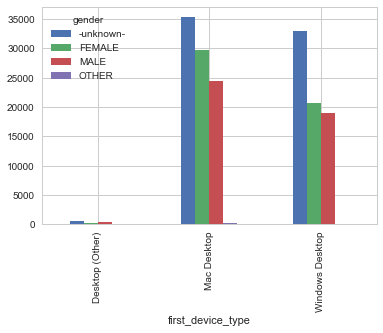

In [46]:
plt.figure(figsize=(12,8))

data5.plot(kind='bar')
plt.xlabel('first_device_type')

plt.show()

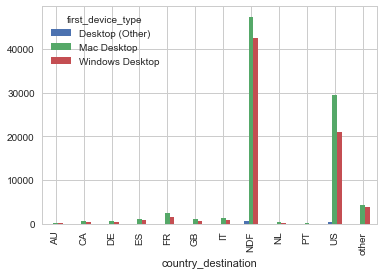

In [88]:
data6 = first_device_type_pc.pivot_table(columns=['first_device_type'], index=['country_destination'], values='id', aggfunc="count")
data6.plot(kind='bar')
plt.xlabel('country_destination')

plt.show()

### Tablet 이용자

In [73]:
first_device_type_tab = pd.concat([train[train.first_device_type == "iPad"], train[train.first_device_type == "Android Tablet"]])
first_device_type_tab.reset_index(drop=True, inplace=True)
first_device_type_tab.tail(3)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
15628,2bnl5yrkku,2014-06-30,20140630200122,NaN,-unknown-,NaN,google,12,en,direct,direct,untracked,Android,Android Tablet,-unknown-,NDF
15629,7plqriggxp,2014-06-30,20140630230136,2014-06-30,-unknown-,55.0,basic,0,en,sem-brand,google,omg,Web,Android Tablet,IE,FR
15630,r0jq0devgy,2014-06-30,20140630234243,NaN,-unknown-,NaN,basic,23,en,direct,direct,untracked,Android,Android Tablet,-unknown-,NDF


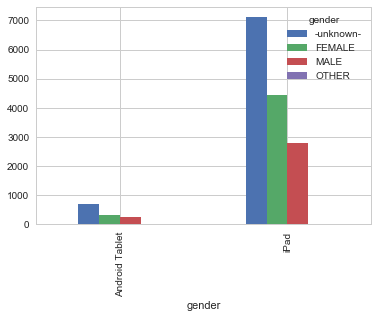

In [75]:
data7 = first_device_type_tab.pivot_table(columns=['gender'], index=['first_device_type'], values='id', aggfunc="count")
data7.plot(kind='bar')
plt.xlabel('gender')

plt.show()

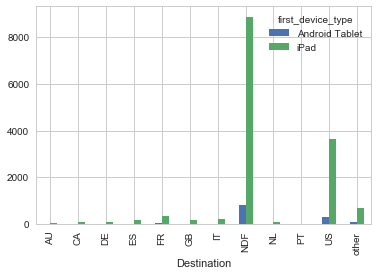

In [78]:
data8 = first_device_type_tab.pivot_table(columns=['first_device_type'], index=['country_destination'], values='id', aggfunc="count")
data8.plot(kind='bar')
plt.xlabel('Destination')

plt.show()

### ios 계열

In [80]:
first_device_type_ios = pd.concat([train[train.first_device_type == "iPhone"], train[train.first_device_type == "iPad"]])
first_device_type_ios.reset_index(drop=True, inplace=True)
first_device_type_ios.tail(3)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
35095,7wmp2uq4pl,2014-06-30,20140630215232,NaN,-unknown-,NaN,basic,25,en,direct,direct,untracked,iOS,iPad,-unknown-,NDF
35096,iu1abga5nx,2014-06-30,20140630224635,2014-06-30,FEMALE,21.0,facebook,0,en,sem-brand,google,omg,Web,iPad,Mobile Safari,ES
35097,2f24umzkuv,2014-06-30,20140630233427,NaN,-unknown-,NaN,basic,0,en,sem-brand,google,untracked,Web,iPad,Mobile Safari,NDF


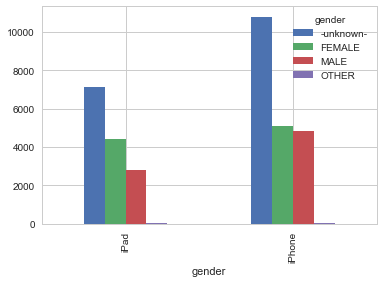

In [81]:
data9 = first_device_type_ios.pivot_table(columns=['gender'], index=['first_device_type'], values='id', aggfunc="count")
data9.plot(kind='bar')
plt.xlabel('gender')

plt.show()

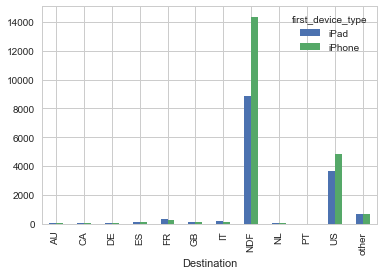

In [82]:
data10 = first_device_type_ios.pivot_table(columns=['first_device_type'], index=['country_destination'], values='id', aggfunc="count")
data10.plot(kind='bar')
plt.xlabel('Destination')

plt.show()

### Android 계열

In [85]:
first_device_type_android = pd.concat([train[train.first_device_type == "Android Phone"], train[train.first_device_type == "Android Tablet"]])
first_device_type_android.reset_index(drop=True, inplace=True)
first_device_type_android.tail(3)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
4092,2bnl5yrkku,2014-06-30,20140630200122,NaN,-unknown-,NaN,google,12,en,direct,direct,untracked,Android,Android Tablet,-unknown-,NDF
4093,7plqriggxp,2014-06-30,20140630230136,2014-06-30,-unknown-,55.0,basic,0,en,sem-brand,google,omg,Web,Android Tablet,IE,FR
4094,r0jq0devgy,2014-06-30,20140630234243,NaN,-unknown-,NaN,basic,23,en,direct,direct,untracked,Android,Android Tablet,-unknown-,NDF


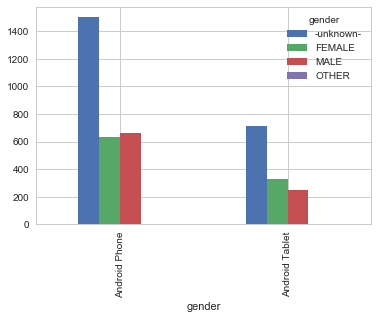

In [86]:
data11 = first_device_type_android.pivot_table(columns=['gender'], index=['first_device_type'], values='id', aggfunc="count")
data11.plot(kind='bar')
plt.xlabel('gender')

plt.show()

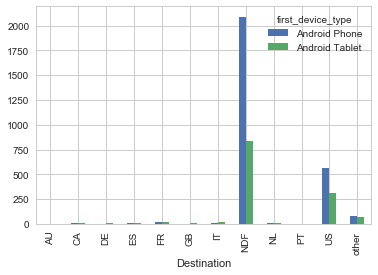

In [87]:
data12 = first_device_type_android.pivot_table(columns=['first_device_type'], index=['country_destination'], values='id', aggfunc="count")
data12.plot(kind='bar')
plt.xlabel('Destination')

plt.show()

## Countries Set

In [57]:
countries.tail()

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
5,GB,54.633220,-3.432277,6883.6590,243610.0,eng,0.00
6,IT,41.873990,12.564167,8636.6310,301340.0,ita,89.40
7,NL,52.133057,5.295250,7524.3203,41543.0,nld,63.22
8,PT,39.553444,-7.839319,7355.2534,92090.0,por,95.45
9,US,36.966427,-95.844030,0.0000,9826675.0,eng,0.00


In [ ]:
train Country_destination에 맞춰서 countires의 distance_km,language_levenshtein_distance

거리는 여행경비와 연관이 있기때문에 충분히 중요한 변수가 될 수 있을 것 같다.

In [63]:
import haversine

In [66]:
countries['haversine_distance'] = countries.apply(lambda r: haversine.haversine(([36.966427, -95.844030]),
                                                                  (r['lat_destination'], r['lng_destination'])), axis=1)
countries

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance,haversine_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00,15297.744201
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00,2828.133504
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61,7879.567727
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25,7730.723946
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06,7682.944550
5,GB,54.633220,-3.432277,6883.6590,243610.0,eng,0.00,6883.659361
6,IT,41.873990,12.564167,8636.6310,301340.0,ita,89.40,8636.630704
7,NL,52.133057,5.295250,7524.3203,41543.0,nld,63.22,7524.320293
8,PT,39.553444,-7.839319,7355.2534,92090.0,por,95.45,7355.253382
9,US,36.966427,-95.844030,0.0000,9826675.0,eng,0.00,0.000000


In [ ]:
distance_km : 미국을 기준으로 haversine_distance를 구한것
destination_km2 : 도착지 영토 크기

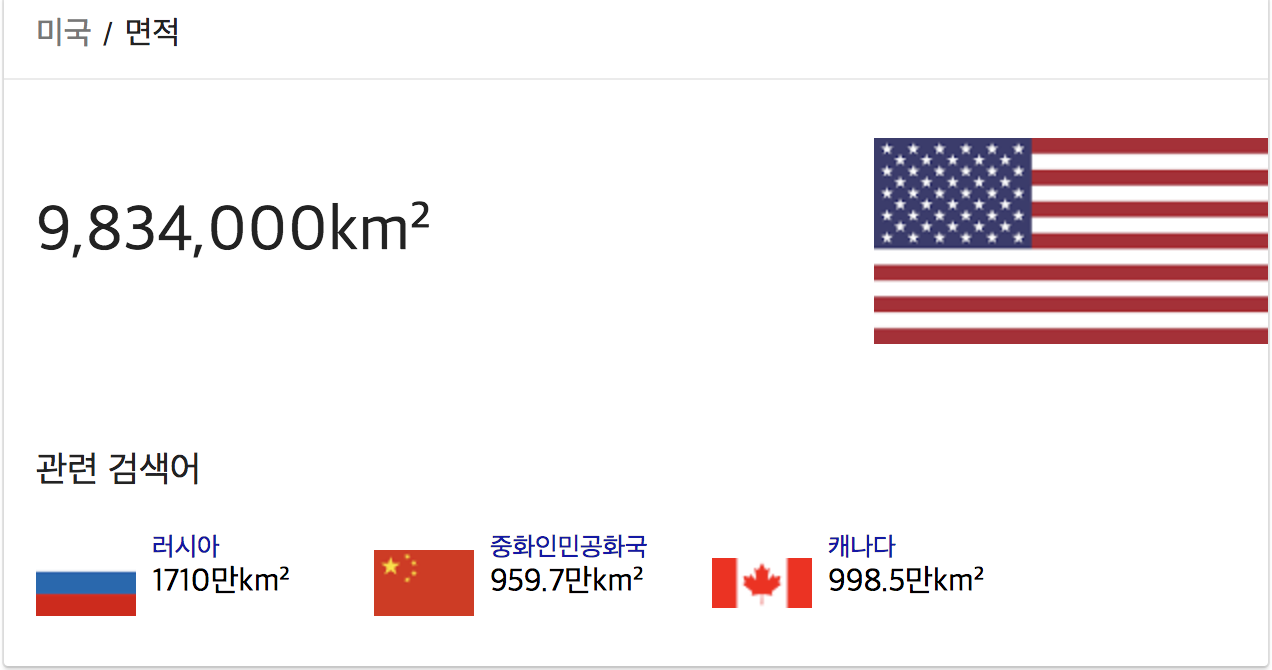

In [71]:
Image.open('destination_km2.png')

In [59]:
import folium
import folium.plugins as plugins
from folium.plugins import MarkerCluster

In [62]:
center=[np.mean(countries['lat_destination']), np.mean(countries['lng_destination'])]

m = folium.Map(
    location = center,
    zoom_start=0)


for i in range(len(countries)):
    location1=[countries.iloc[i, 1], countries.iloc[i, 2]]
    folium.CircleMarker(
        location=location1,
        radius=1,
        color = "blue"
      ).add_to(m)
    marker = folium.Marker(location=location1)
m

여기어때
전체 회원 중 구매전환율(바로예약을 의미)은 40% 정도 된다.

In [ ]:
등록일 - 첫 부킹

#### Train Data Set에서 활용할 수 있는 요소

1. 성별 / 연령 / 국적(거주지) : 언어

2. 거주지와 목적지 간 이동시간

3. 날짜정보 - 계절요인, 시기별

4. 시계열분석해서 시간에 따른 추세를 파악해볼까? (유행인 관광지)

인구ㆍ사회통계특성은 성별, 연령, 국적, 직업, 결혼, 소득, 학력, 거주지

여행특성은 동반유형, 동반자수, 여행형태, 방문유무, 방문횟수, 여행기간, 거주지와 목적지 간 이동시간

성격특성은 경험에 대한 개방성, 성실성, 외향성, 친화성, 신경증적 경향성을 포함한 세부정보 중 하나 이상을 포함하며, 

행동영향요인특성은 태도, 규범, 통제, 상황특성, 개인특성

일본: 20대(27%) 미혼(42%)이 개별여행 방식(58%)으로 방문해 놀이/테마공원/온천 등 즐기기 (20%), 휴식(18%), 식도락(17%)을 즐기고자 하는 곳.

중국: 5-60대(57%) 남성(58%)이 단체 패키지(51%)로 가서 자연 풍경 감상(34%)하고, 역사/유적 감상(23%)을 주 목적으로 하는 곳.

유럽: 경제적으로 여유 있는(월수입 7백만원 이상 36%) 시니어들이 역사/유적(36%)과 도시 경관(22%)을 감상하기 위해 패키지여행(37%)을 계획 하는 곳.

미주(미국/하와이/캐나다): 고소득(월수입 7백만원 이상 41%) 남성(53%)이 친지/친구/친척 만나기(23%), 휴식(20%), 자연 풍경 감상(20%)등의 다양한 목적을 위해 개별여행(54%)을 계획하는 곳.

대양주: 3-40대(48%) 기혼(72%) 여성(54%)이 자연 풍경 감상(32%)과 휴식(28%)을 위해 찾는 곳. 상대적으로 에어텔 패키지가 많음(19%).

홍콩/마카오: 2-30대(56%) 미혼(43%) 여성(59%)이 도시 경관 감상(28%), 쇼핑(19%), 식도락(17%)을 위해 개별여행(52%)을 계획하는 곳.